# 1.1 Setup a Folder:

---






In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import os
if not os.path.isdir("Pneumonia"):
  os.makedirs("Pneumonia")
%cd Pneumonia

/content/drive/MyDrive/Pneumonia


## 1.2 Donwloading DataSet:

---





In [ ]:
!pip install opendatasets
import opendatasets as od
if not os.path.isdir("chest-xray-pneumonia"):
  od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2.1 Exploring & Visualize The Data:

---






In [ ]:
for directory in (os.listdir('chest-xray-pneumonia/chest_xray')[2:]):
  for folder in os.listdir(f"chest-xray-pneumonia/chest_xray/{directory}"):
      print(f"The Number Of {folder} {directory} Images: "+str(len((os.listdir(f'chest-xray-pneumonia/chest_xray/{directory}/{folder}')))))

The Number Of NORMAL test Images: 234
The Number Of PNEUMONIA test Images: 390
The Number Of NORMAL train Images: 1341
The Number Of NORMAL val Images: 8
The Number Of PNEUMONIA val Images: 8


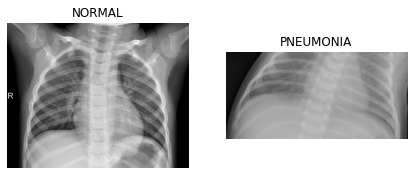

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
for number,folder in enumerate(os.listdir('chest-xray-pneumonia/chest_xray/train')):
  names=os.listdir('chest-xray-pneumonia/chest_xray/train/'+folder)
  indx=np.random.randint(len(names))
  img=plt.imread(f"chest-xray-pneumonia/chest_xray/train/{folder}/{str(names[indx])}")
  plt.subplot(1,4,number+1)
  plt.imshow(img,cmap="gray")
  plt.title(str(folder))
  plt.axis('off')

<BarContainer object of 2 artists>

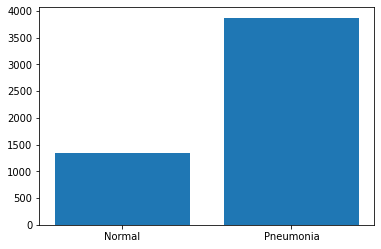

In [ ]:
#In Trainning:
train_path="chest-xray-pneumonia/chest_xray/train"
normal=os.listdir(train_path+"/NORMAL")
pneumonia=os.listdir(train_path+"/PNEUMONIA")

#Plotting
x=["Normal","Pneumonia"]
y=[len(normal),len(pneumonia)]
plt.bar(x,y)

There is a Class Imblance 
so we will make a weight for trainning.

In [ ]:
weight_for_0 = (1 / len(normal))*(len(normal)+len(pneumonia))/2.0 
weight_for_1 = (1 / len(pneumonia))*(len(normal)+len(pneumonia))/2.0 

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
No_drop= len(pneumonia) - len(normal)
for i in range(No_drop):
      index=np.random.randint(len(pneumonia))
      pneumonia.remove(pneumonia[index])

1341


<BarContainer object of 2 artists>

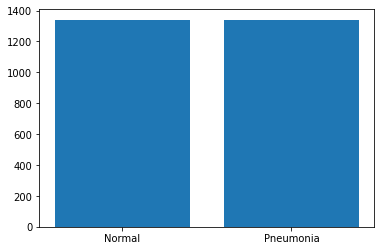

In [ ]:
#deleting images to make 2 classes equal:
folder=os.listdir(train_path+"/PNEUMONIA")
for i in folder:
    if not i in pneumonia:
        #y.append(1)
        os.remove(f"{train_path}/PNEUMONIA/{i}")


pneumonia=os.listdir(train_path+"/PNEUMONIA")

#Plotting
x=["Normal","Pneumonia"]
y=[len(normal),len(pneumonia)]
plt.bar(x,y)

##2.2 Data Augmentation & Loading :
---


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
Size=150
B_size=64
Training_path='chest-xray-pneumonia/chest_xray/train'
train_datagen=ImageDataGenerator(rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)
train_generator=train_datagen.flow_from_directory(Training_path,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(Size,Size))

Found 5216 images belonging to 2 classes.


(-0.5, 149.5, 149.5, -0.5)

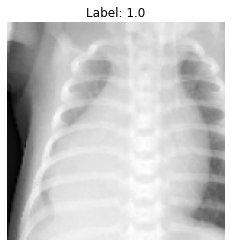

In [ ]:
#Viz Data From Generator
import matplotlib.pyplot as plt
Image,Y=next(train_generator)
plt.imshow(Image[0],cmap="gray")
plt.title("Label: "+str(Y[0]))
plt.axis('off')

In [ ]:
validation_path='chest-xray-pneumonia/chest_xray/val'
validation_datagen=ImageDataGenerator(rescale=1./255)
val_generator=validation_datagen.flow_from_directory(validation_path,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(Size,Size))

Found 16 images belonging to 2 classes.


# 3.1 Create Model:

---



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dropout,Flatten,Dense,Input,SeparableConv2D
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.metrics import Precision,Recall

In [ ]:
model=Sequential([
    SeparableConv2D(64,3,activation='relu',input_shape=(150,150,1)),
    SeparableConv2D(64,3,activation='relu'),
    MaxPooling2D((2,2)),
    SeparableConv2D(32,3,activation='relu'),
    SeparableConv2D(32,3,activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(.3),
    Dense(64,activation='relu'),
    Dense(1,activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 148, 148, 64)     137       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 146, 146, 64)     4736      
 leConv2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_2 (Separab  (None, 71, 71, 32)       2656      
 leConv2D)                                                       
                                                                 
 separable_conv2d_3 (Separab  (None, 69, 69, 32)       1

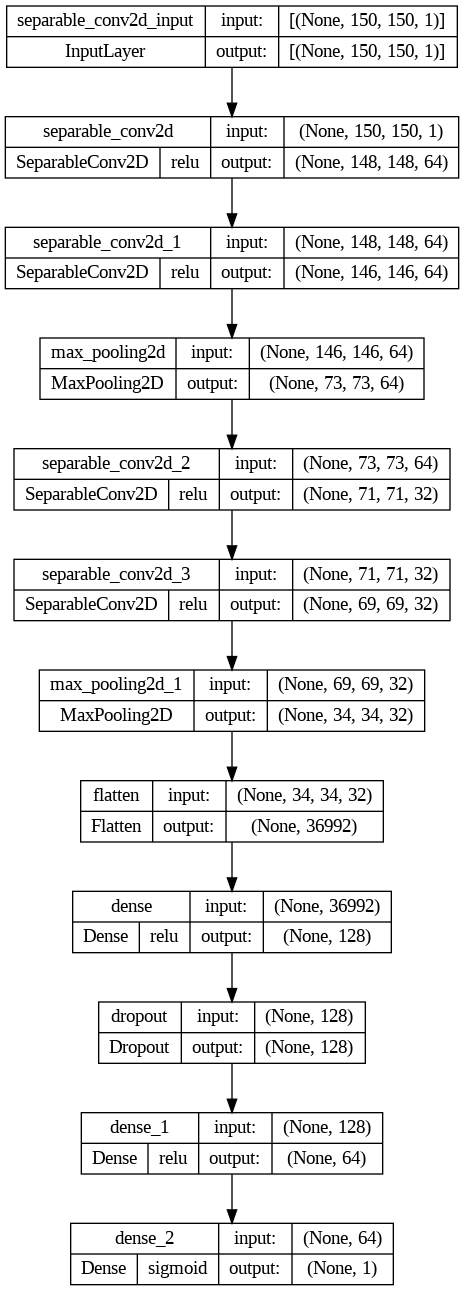

In [ ]:
plot_model(model,show_shapes=True,expand_nested=True,show_layer_activations=True)

In [ ]:
#model compilation:
model.compile(optimizer ="adam",loss='binary_crossentropy',metrics= ['accuracy', Precision(name='percesion'),Recall(name='recall')])

# 3.2 Trainning:

---



In [ ]:
epoch=100
steps=int(len(train_generator))
val_steps=int(len(val_generator))
history=model.fit(train_generator,
                  epochs=epoch,
                  steps_per_epoch=steps,
                  validation_steps=val_steps,
                  validation_data=val_generator,
                  class_weight=class_weight)

Epoch 1/100
82/82 [==============================] - 923s 11s/step - loss: 0.6928 - accuracy: 0.6377 - percesion: 0.7484 - recall: 0.7716 - val_loss: 0.6907 - val_accuracy: 0.5000 - val_percesion: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
82/82 [==============================] - 70s 855ms/step - loss: 0.4080 - accuracy: 0.8250 - percesion: 0.9283 - recall: 0.8284 - val_loss: 0.7045 - val_accuracy: 0.7500 - val_percesion: 0.7500 - val_recall: 0.7500
Epoch 4/100
82/82 [==============================] - 70s 855ms/step - loss: 0.3754 - accuracy: 0.8355 - percesion: 0.9351 - recall: 0.8366 - val_loss: 0.5463 - val_accuracy: 0.8125 - val_percesion: 0.8571 - val_recall: 0.7500
Epoch 5/100
82/82 [==============================] - 70s 854ms/step - loss: 0.3463 - accuracy: 0.8551 - percesion: 0.9444 - recall: 0.8552 - val_loss: 0.7175 - val_accuracy: 0.6250 - val_percesion: 0.6667 - val_recall: 0.5000
Epoch 6/100
82/82 [==============================] - 70s 853ms/step - loss: 0.3208 - accu

KeyboardInterrupt: ignored

# 3.3 Evaluation & Predicting:

---



In [ ]:
Testing_path='chest-xray-pneumonia/chest_xray/test'
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(Testing_path,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(Size,Size))

Found 624 images belonging to 2 classes.


In [ ]:
model.evaluate(test_generator,steps=len(test_generator))

10/10 [==============================] - 80s 9s/step - loss: 0.2784 - accuracy: 0.8830 - percesion: 0.8856 - recall: 0.9333


[0.27844879031181335,
 0.8830128312110901,
 0.885644793510437,
 0.9333333373069763]

In [ ]:
y_true = test_generator.classes
Y_pred = model.predict(test_generator, steps = len(test_generator))
y_pred=np.round(Y_pred)

10/10 [==============================] - 6s 550ms/step


In [ ]:
print(y_true[0])
print(y_pred[0])

0
[0.]


In [ ]:
model.save('pnemonia.hdf5')